# Welcome to the lab tree notebook!
#### Jonathan bac, Alexis Casas

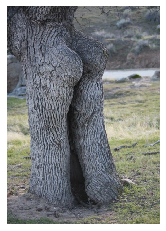

In [3]:
import matplotlib.image as mpimg; import matplotlib.pyplot as plt
plt.imshow(mpimg.imread('labtree.jpg')[100:-100]); plt.axis('off'); plt.show()

Last year we had the goal to make an automated lab tree. This effort was only partly successful - making a fully automated lab tree is not an easy task and quite time-consuming. It would allow, however, large-scale analyses of different PIs' careers. More importantly it would reduce the suffering of future generations of M2 students. 

We pass the torch onto you if you wish to take on this noble task and continue our efforts. If you attempt this you should also contact Marc Santolini from CRI. He was very interested in this and if you succeed in collecting data over many teams you can probably try to write a publication.  

As of now, using this notebook you should be able to:
   - retrieve titles, authors, abstracts, etc from a scientist's google scholar profile
   - retrieve full-text publications using scihub (/!\ if you have a proxy or lots of patience)
   - do basic analysis of the collected data (cluster similar publications, explore relations between co-authors)
   
Unfortunately google scholar and scihub protect themselves from automated requests to their websites. After some time running our scripts they will block your IP or display a CAPTCHA, which will prevent the scripts from working.  

Circumventing this issue requires you to either wait some time or to change your IP. To change your IP you can simply connect to a different WiFi. If you want to automate IP switching, the best way is to use Tor or subscribe to a free or paid VPN service and then link it to Python. However both these options require quite a bit of extra setup on your part.

A third option for the most daring would be to automatically solve the CAPTCHAs using a service like https://2captcha.com through Python. However this requires to pay .5$ / 1000 CAPTCHAs. You can also then use the solved CAPTCHAs to train a neural network and not have to pay anymore. You can find in the folder `captchas` some solved examples

Have fun !

### Install some packages you might be missing

In [1]:
!pip install bokeh --user
!pip install umap-learn --user
!pip install plotly --user
!pip install seaborn --user
!pip install gensim --user
!pip install nltk --user
!pip install scikit-learn --user
!pip install tika --user

^C
Traceback (most recent call last):
  File "/home/utilisateur/anaconda3/bin/pip", line 7, in <module>
    from pip._internal.cli.main import main
  File "/home/utilisateur/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/home/utilisateur/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/home/utilisateur/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/home/utilisateur/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/cmdoptions.py", line 28, in <module>
    from pip._internal.models.target_python import TargetPython
  File "/home/utilisateur/anaconda3/lib/python3.7/site-packages/pip/_internal/models/target_python.py", line 4, in <module>
    from pip._inter

### Load packages

In [4]:
#our scripts are inside these two modules
from analyze_coauthors import build_and_draw_graph
from get_data import get_scholar_summary, download_papers, which_papers_are_missing, get_abstracts, tika_pdf_to_text

import os
import urllib.request as urllib
import bs4
import re
import requests
import json
import subprocess
import pickle
import numpy as np
import plotly.graph_objs as go
import umap
import pandas as pd
import seaborn as sns
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist,squareform
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

### Get information on an author's publications from google scholar
If your author has more than 100 publications, google scholar will probably block your IP adress at some point. 

In such a case, simply save the current results and wait or change your IP (using a proxy service for example or even more simply using a different wifi). Then relaunch the function and change START_FROM_PUBLI_NUMBER to avoid retrieving once again publications you already have (if you already have 80 publications, set it to 80).

In [2]:
AUTHOR_NAME = 'Tom_Ellis'
AUTHOR_SCHOLAR_ID = "3j1vzfQAAAAJ" #we get Tom Ellis's scholar ID from his google scholar page url: https://scholar.google.com/citations?user=3j1vzfQAAAAJ&hl=en#

In [9]:
publications, titles, links = get_scholar_summary(AUTHOR_SCHOLAR_ID,NB_MAX_PUBLIS=1000,START_FROM_PUBLI_NUMBER=0)

Google blocked the request to access the page. Wait a few hours or change your IP adress and retry.
 You can save the 98 collected publications. When you relaunch the function use the option START_FROM_PUBLI_NUMBER= 98 to ignore the publications you already got


### Save the results

In [11]:
with open(AUTHOR_NAME+'-googlescholar-publications.json', "w") as fp:
    json.dump(publications, fp)
with open(AUTHOR_NAME+'-googlescholar-titles.pickle', "wb") as fp:
    pickle.dump(titles, fp)
with open(AUTHOR_NAME+'-googlescholar-links.pickle', "wb") as fp:
    pickle.dump(links, fp)

### Load your results

In [3]:
with open(AUTHOR_NAME+'-googlescholar-publications.json') as f:
    publications=json.load(f)
with open(AUTHOR_NAME+'-googlescholar-titles.pickle','rb') as fp:
    titles=pickle.load(fp)
with open(AUTHOR_NAME+'-googlescholar-links.pickle','rb') as fp:
    links=pickle.load(fp)

### Download full-text articles
Clustering similar articles based on the title or abstract is difficult because little text is available.

Downloading full articles and analyzing them provides a much richer source of information. Unfortunately retrieving full-text articles automatically is much harder than abstracts. The easiest is to ask the author directly for his papers. Alternatively you can try the script below which uses scihub; however if you don't use a proxy scihub will block you very frequently with CAPTCHAs. Collected papers will be saved in the folder `collected_papers`, each in a separate folder. If the folder for a article is empty, the collection failed

In [5]:
papers = download_papers(links, titles, num_retries = 10)

KeyboardInterrupt: 

In [4]:
missing_papers, collected_papers = which_papers_are_missing(links, titles)

32 collected papers, 66 missing papers


### Data analysis
Once you have collected google scholar information, you can load the data and do whatever analysis you want.
For example you can try to cluster publications based on the similarity of their abstract or title.
You can also form a graph linking the different coauthors of your chosen PI

#### Create a graph of coauthors
You can use and modify the function below. It uses the .json file of publications you saved in the previous step to create a file `interactive_graphs.html` and open it in your browser. Authors (purple nodes) are linked to their coauthors and publications (grey nodes). Usually some publications appearing in google scholar are not real ones and might pollute your graph, so you should remove those.

In [14]:
#ugly graph polluted by scholar entries that are not real publications
x = build_and_draw_graph(AUTHOR_NAME+'-googlescholar-publications.json')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/utilisateur/labtree/analyze_coauthors.py:68: UserWarning:

Publication has no date:High-‐throughput picodroplet-‐based analysis of biosynthetic libraries

/home/utilisateur/labtree/analyze_coauthors.py:68: UserWarning:

Publication has no date:regulatory component libraries for synthetic biology

/home/utilisateur/labtree/analyze_coauthors.py:68: UserWarning:

Publication has no date:Synthetic Biology Synthetic biology of antibiotic production



Wintle Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Boehm Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Rhodes Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Molloy Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Millett Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Adam Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Breitling Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Carlson Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Casagrande Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Dando Point of View: A transatlantic perspective on 20 emerging issues in biological engineering
Doubleday Point

ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='1025', ...)


In [ ]:
#pretty graph obtained by deleting some publications in the .json file
x = build_and_draw_graph('pretty.json')

#### Cluster publications
You can try grouping related publications based on the similarity of their titles or abstracts. However clustering based on this alone will probably be pretty uninformative. The ideal is to use full texts if you can get your hand on them

In [4]:
abstracts, abstracts_titles = get_abstracts(publications)

Synthetic biology-a primer: revised edition had no abstract
526 A potent PBD-heterocyclic polyamide conjugate targeting an ICB2 transcription factor binding site had no abstract


In [32]:
#you can compute similarity/distance matrices between abstracts the way you want
#TfidfVectorizer and CountVectorizer methods can also provide you with most frequent words, keywords, word scores,...

vect = TfidfVectorizer(max_df = .8,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
tfidf = vect.fit_transform(abstracts)
distance_matrix = np.abs(1-(tfidf@tfidf.T).A)
np.fill_diagonal(distance_matrix,0)

count = CountVectorizer(max_df = .8,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
cv_fit=count.fit_transform(abstracts)

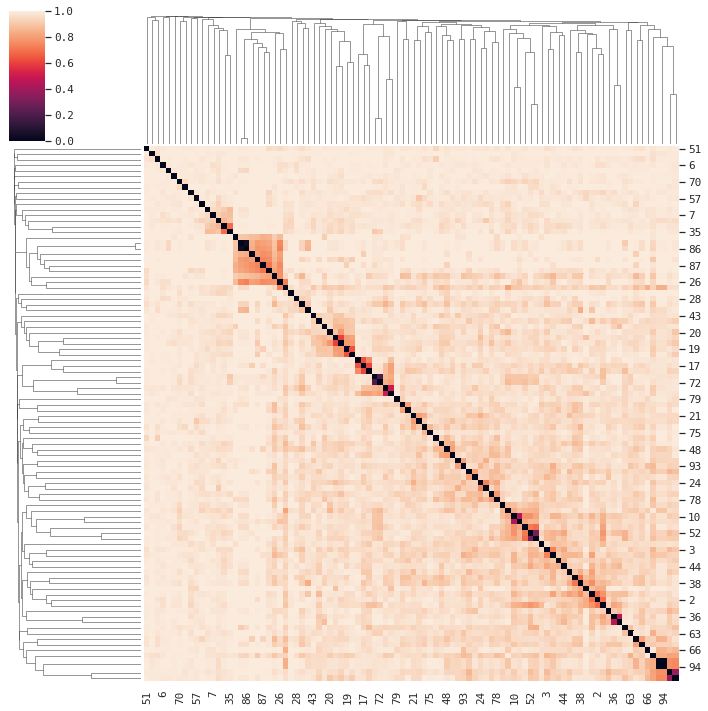

In [34]:
linkage = hc.linkage(squareform(distance_matrix), method='average')
sns.clustermap(distance_matrix, row_linkage=linkage, col_linkage=linkage)

In [46]:
   #you can vary eps to modify the clustering
cluster = DBSCAN(eps=.88,min_samples=1,metric= "precomputed",algorithm="brute")
papers_clustering = cluster.fit_predict(distance_matrix)
papers_clustering

array([ 0,  0,  0,  0,  0,  1,  2,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  4,  0,  0,  0,  0,  4,  0,  0,  0,  0,  5,  0,  6,  0,  0,  0,
        0,  4,  0,  0,  0,  0,  4,  7,  0,  8,  0,  0,  0,  0,  0,  0,  0,
        9,  0,  0, 10,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,
        0, 13, 14,  0,  0,  0,  0,  0,  0,  0,  0, 15, 16,  0, 17,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

### More sophisticated clustering based on full texts
The first thing to do is to try extracting text from the pdfs (tika didn't work very well so you can try to find something else) 

In [3]:
#/!\ tika requires Java 7+ to be installed on your computer
parsed_pdfs = tika_pdf_to_text()
#save results
with open('parsed_pdfs','wb') as f:
    pickle.dump(parsed_pdfs,f)

2020-03-25 12:57:48,209 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2020-03-25 12:58:06,820 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2020-03-25 12:58:07,365 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


IsADirectoryError: [Errno 21] Is a directory: '/home/utilisateur/labtree/collected_papers/2, 3-Bifunctionalized quinoxalines: synthesis, DNA interactions and evaluation of anticancer, anti-tuberculosis and antifungal activity/.ipynb_checkpoints'

In [24]:
#load results
with open('parsed_pdfs','rb') as f:
    parsed_pdfs=pickle.load(f)
publications_texts = [i[1] for i in parsed_pdfs]

In [42]:
#clean the collected texts

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

publications_texts = [i[1] for i in parsed_pdfs]
clean_text = [i.lower() for i in publications_texts]
for i in range(len(text)):
    clean_text[i] = ' '.join([word for word in text[i].split() if word not in (stopwords.words('english'))])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/utilisateur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/utilisateur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You can then train a Doc2Vec embedding based on full-texts to try having better clustering results

In [45]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(clean_text)]

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('\riteration {0}'.format(epoch),end='\r')
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("\nModel Saved")

/home/utilisateur/.local/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.



iteration 0

/home/utilisateur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).



iteration 99Model Saved


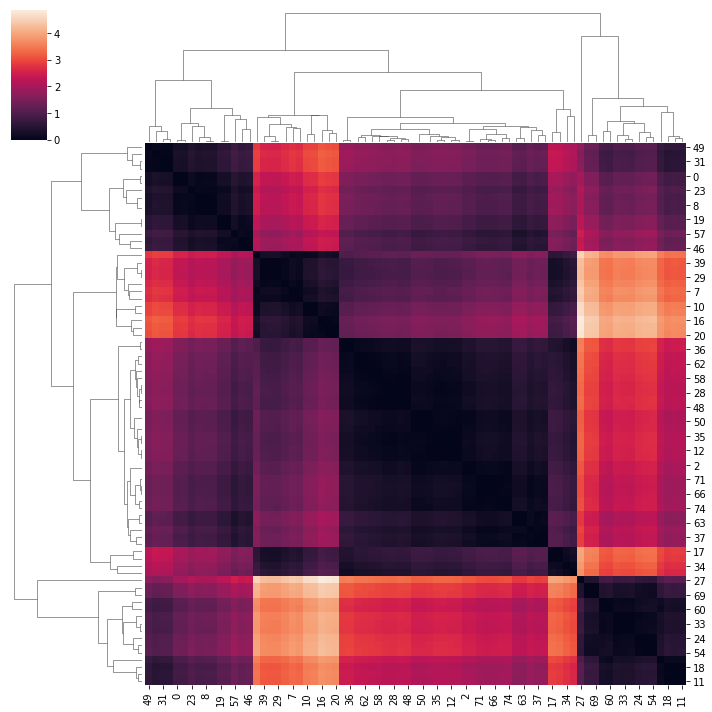

In [67]:
#load previously trained model
model= Doc2Vec.load("d2v.model")

#embed the documents
doc_space = np.zeros((len(text),20))
for i in range(len(text)):
    doc_space[i]=model.docvecs[str(i)]
    
#reduce dimensions UMAP
u = umap.UMAP(n_components=2,n_neighbors=10)
embedding=u.fit_transform(doc_space)
    
#compute new distance matrix, create clustering using the first component of UMAP space (or whatever number of components you choose)
distance_matrix=squareform(pdist(embedding[:,:1], metric='euclidean'))
linkage = hc.linkage(squareform(distance_matrix))
sns.clustermap(distance_matrix, row_linkage=linkage, col_linkage=linkage)

In [70]:
#make clusters using DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.48, min_samples=2).fit(embedding)
labels = db.labels_
from collections import Counter
Counter(labels)

Counter({0: 19, 1: 12, 2: 11, 3: 15, 4: 10, 5: 7, -1: 1})

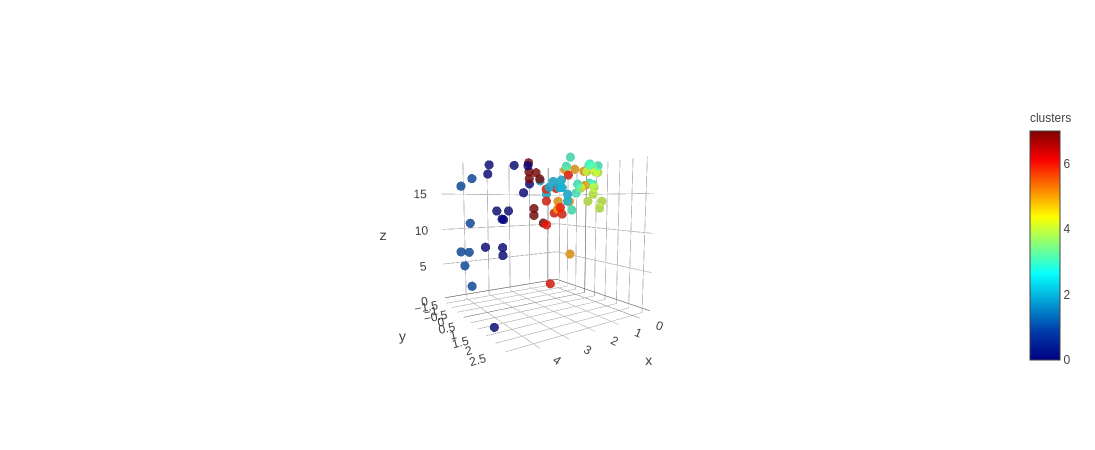

In [452]:
#plot UMAP embedding using plotly, 3rd dimension represents time
#
#trace1 = go.Scatter3d(
#    x=embedding[:,0],
#    y=embedding[:,1],
#    z=dates,
#    mode='markers',
#    marker=dict(size=3,color=y_km,colorscale='Jet',colorbar=dict(title='clusters')),opacity=0.8)
#
#fig = go.Figure(data=[trace1])
#iplot(fig, filename='3d-scatter-colorscale')